---

Passo 1: Carregar logs

In [1]:
# 1
import pandas as pd
import json
from unidecode import unidecode
import random as rd

# 2
import nltk
import os

# 3
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

# 4
import cupy
import cupyx
import cupyx.scipy.sparse
import cupyx.scipy.linalg

In [2]:
try:
    stopwords = list(nltk.corpus.stopwords.words('english'))
    stopwords.extend(['project', 'et', 'al'])

except LookupError:
    nltk.download('stopwords')
    stopwords = list(nltk.corpus.stopwords.words('english'))
    stopwords.extend(['project', 'et', 'al'])

---

Passo 2: Pré-processamento

In [3]:
def decode(s) -> str:
	return unidecode(s).replace("_", " ").strip().lower()

In [4]:
def stem(text: pd.DataFrame) -> pd.DataFrame:
    stemmed = text

    stemmer = nltk.SnowballStemmer('english')
    stemmed = stemmed.str.split().apply(lambda x: [stemmer.stem(y) for y in x])
    stemmed = stemmed.apply(lambda x: ' '.join(x))
    
    return stemmed

In [5]:
df_labeled: pd.DataFrame
df_unknown: pd.DataFrame

CSV_LABELED: str = "df_labeled.csv"
CSV_UNKNOWN: str = "df_unknown.csv"
CSV_TRAINING: str = "df_training.csv"
CSV_TESTING: str = "df_testing.csv"
FORCE_RELOAD: bool = True

if not FORCE_RELOAD and all(filename in os.listdir() for filename in [CSV_LABELED, CSV_TESTING, CSV_TRAINING, CSV_UNKNOWN]):
	import ast

	def list_converter(list_string):
		try:
			return ast.literal_eval(list_string)
		except (ValueError, SyntaxError):
			# Handle cases where the string is not a valid list representation
			return [] # or None, or the original string, depending on your needs

	df_unknown = pd.read_csv(CSV_UNKNOWN, converters={'areas': list_converter})
	df_training = pd.read_csv(CSV_TRAINING, converters={'areas': list_converter})
	df_testing = pd.read_csv(CSV_TESTING, converters={'areas': list_converter})
	df_labeled = pd.read_csv(CSV_LABELED, converters={'areas': list_converter})

else:
	data = []

	with open("data_complete.json", "r", encoding="utf8") as fs:
		data = json.loads(fs.read())

	print("All %d data rows loaded!"%len(data))
	for row in data:
		row["abstract"] = decode(row["abstract"] + " " + row["title"])
	print("All %d data rows decoded!"%len(data))

	rd.shuffle(data)

	data_labeled: list = []
	data_unknown: list = []

	for row in data:
		if row["areas"]:
			data_labeled.append(row)
		else:
			data_unknown.append(row)
	print("All %d data rows sorted into 'labeled' (%d) and 'unknown' (%d)!"%(len(data), len(data_labeled), len(data_unknown)))

	df_labeled: pd.DataFrame = pd.DataFrame(data_labeled)
	df_unknown: pd.DataFrame = pd.DataFrame(data_unknown)

	df_labeled["abstract"] = stem(df_labeled["abstract"])
	df_unknown["abstract"] = stem(df_unknown["abstract"])

	print("All data stemmed!")
	df_labeled.to_csv(CSV_LABELED)
	df_unknown.to_csv(CSV_UNKNOWN)

	df_training = df_labeled[:int(len(df_labeled)/2)]
	df_testing = df_labeled[int(len(df_labeled)/2):]

	df_training.to_csv(CSV_TRAINING)
	df_testing.to_csv(CSV_TESTING)

	print("All data saved to CSVs!")

display(df_training)
display(df_testing)
display(df_unknown)
print([area for area in df_training["areas"]])


All 297957 data rows loaded!
All 297957 data rows decoded!
All 297957 data rows sorted into 'labeled' (125839) and 'unknown' (172118)!
All data stemmed!
All data saved to CSVs!


lattes                                              areas  \
0      2431933210249177                              [direito do trabalho]   
1      8374950313063279  [questoes sobre deus, espiritualidade, teologi...   
2      5111433441625035                       [linguistica letras e artes]   
3      2129172897640183                           [sociologia do trabalho]   
4      4625110658118253                          [jornalismo e editoracao]   
...                 ...                                                ...   
62914  8249534204731109                      [cad, sistemas de informacao]   
62915  6935503527357767                          [fenomenos de transporte]   
62916  6678412027279043                        [supercondutores ceramicos]   
62917  5818660661319963           [filosofia publica, politica brasileira]   
62918  2014327112277784                       [ciencias sociais aplicadas]   

                                         tag  \
0      2431933210249177-d0195e585ef66352972a   
1      8374950313063279-63301e0d059fcb26b5d3   
2      5111433441625035-82790b17acb051f11ccc   
3      2129172897640183-d4ef7d119988673219d4   
4      4625110658118253-864e19479aec3e50e803   
...                                      ...   
62914  8249534204731109-c84bcd41403e0d3f7a25   
62915  6935503527357767-c153560fd4be4c6df050   
62916  6678412027279043-31e63cf1ad8bf44e8273   
62917  5818660661319963-5313d763a85b3229828b   
62918  2014327112277784-4d4df6528fdf935002b6   

                                                   title  \
0      1st Meeting of the Brazilian delegation of You...   
1      Poverty and grace.  A study on "Malheur" and t...   
2      The cordial man and the translated man: modern...   
3      The ideology of precarious work: the requireme...   
4      Digital tools in the classroom and the teachin...   
...                                                  ...   
62914  Integrated Cad Systems and Process Rengineerin...   
62915  Optimization of reactive flow using magnetic f...   
62916  Influence of Processing Parameters of Partial-...   
62917                          Judicialization of Policy   
62918   GEDHJUS - Human Rights and Justice Studies Group   

                                     doi  \
0                                          
1                                          
2                                          
3                                          
4                                          
...                                  ...   
62914                                      
62915                                      
62916  10.1016/j.matchemphys.2004.11.026   
62917                                      
62918                               None   

                                                abstract  year  
0      1st meet of the brazilian deleg of youth juris...  2017  
1      poverti and grace. a studi on "malheur" and th...  2011  
2      the cordial man and the translat man: modern i...  2008  
3      the ideolog of precari work: the requir of lab...  2013  
4      digit tool in the classroom and the teach of t...  2014  
...                                                  ...   ...  
62914  integr cad system and process rengin in the co...  1995  
62915             optim of reactiv flow use magnet field  2015  
62916  influenc of process paramet of partial-melt pr...  2005  
62917                                   judici of polici  2012  
62918       gedhjus - human right and justic studi group  2014  

[62919 rows x 7 columns]

lattes                                              areas  \
62919   0823104792141767  [ciencias humanas, filosofia e a questao ambie...   
62920   5474816081285023                                   [moral conjugal]   
62921   5480574822219430                       [ciencias sociais aplicadas]   
62922   9171678019364477              [teologia biblica, teologia pastoral]   
62923   0749852550019627                               [comunicacao visual]   
...                  ...                                                ...   
125834  3170892322346589                       [ciencias sociais aplicadas]   
125835  7003206044726098          [ciencias humanas, sociologia, geografia]   
125836  2192738260572343                             [comunicacoes opticas]   
125837  9094759402599071      [combustao e escoamento com reacoes quimicas]   
125838  4831269110581681                                 [ciencias humanas]   

                                          tag  \
62919   0823104792141767-d121af39e9acba429293   
62920   5474816081285023-8bb92a6ca5631b7cb2d5   
62921   5480574822219430-574e8c282a5f30826746   
62922   9171678019364477-8068e5e2f2177542afdc   
62923   0749852550019627-c3ee40abff8d63d88d05   
...                                       ...   
125834  3170892322346589-f0ca781f2d95a30fffc2   
125835  7003206044726098-14a0ec6815e6d8684a34   
125836  2192738260572343-1452ee5f2c0cd100ad2c   
125837  9094759402599071-b240aa6f4765f8469d82   
125838  4831269110581681-5a72ac3be46df88fce49   

                                                    title  \
62919   From the inconvenient truth to sufficient: cos...   
62920   The Encyclical Letter Evangelium Vitae. Reflec...   
62921   Documentary series on television: African Pop ...   
62922   Christian participation in the liturgy from 1 ...   
62923       Band Anim'Arte. Visual Identity and Event Set   
...                                                   ...   
125834                           Final Graduation Project   
125835  Environmental Rights in the Amazon: Challenges...   
125836  Using Tunable Coherent Reflectometry to Optimi...   
125837  Numerine Etitude of L'Alumage et du Développem...   
125838  Coexistence space, interdisciplinary study on ...   

                                       doi  \
62919   10.23925/1809-8428.2021v18i1p37-49   
62920                                        
62921                                        
62922                                        
62923                                        
...                                    ...   
125834                                       
125835                                       
125836                                       
125837                                       
125838                                       

                                                 abstract  year  
62919   anthropocen - the new geolog time in which the...  2021  
62920   the encycl letter evangelium vitae. reflect on...  1996  
62921   abstract there is a scarciti of research on do...  2017  
62922   christian particip in the liturgi from 1 pedro...  2024  
62923          band anim'arte. visual ident and event set  2007  
...                                                   ...   ...  
125834                              final graduat project  2012  
125835  environment right in the amazon: challeng and ...  2016  
125836  use tunabl coher reflectometri to optim erbium...  2004  
125837  numerin etitud of l'alumag et du developp de l...  1991  
125838  coexist space, interdisciplinari studi on soci...  2009  

[62920 rows x 7 columns]

lattes areas                                    tag  \
0       5016950162930775    []  5016950162930775-ff799cb4a927a8c4e8e3   
1       8822284125037565    []  8822284125037565-e46b92027f0c0cc08d02   
2       4788131579238903    []  4788131579238903-903ccc31f38988412380   
3       3172784582436163    []  3172784582436163-bd4e21525bf85c2d99c3   
4       5691355417518749    []  5691355417518749-5eb5c5fc1b2458f2038a   
...                  ...   ...                                    ...   
172113  8588362716481924    []  8588362716481924-b9836277bc3280aeac01   
172114  3714198751601144    []  3714198751601144-1eb06a301e46937a42d9   
172115  8424786953911830    []  8424786953911830-177bc9ddbb4eda8d6dfa   
172116  9900625695933750    []  9900625695933750-fdc30cf337a66d02d169   
172117  0967389593663820    []  0967389593663820-8419336160ea01d7d9b4   

                                                    title  \
0       Dam full wave modeling and flood risk at Glaxo...   
1                                III IBNEC Annual Meeting   
2         The guiding principles of PPPs in Brazilian law   
3       Atmospheric chemistry of isopropyl formate and...   
4       Synthesis and Characterization of Fluorescent ...   
...                                                   ...   
172113  Quantum Communication and Computation (and Som...   
172114    Bilingual teacher for the deaf: formative paths   
172115       UBI's intellectual orbit, twenty years later   
172116  Evaluation of Impact Energy Absorption by Natu...   
172117                                                  .   

                        doi  \
0                             
1                             
2                             
3         10.1002/kin.20498   
4                             
...                     ...   
172113                        
172114                        
172115                        
172116  10.3390/app15020653   
172117                        

                                                 abstract  year  
0       dam full wave model and flood risk at glaxosmi...  2020  
1                                   iii ibnec annual meet  2012  
2              the guid principl of ppps in brazilian law  2007  
3       format are produc in the atmospher as a result...  2010  
4       synthesi and character of fluoresc silica nano...  2023  
...                                                   ...   ...  
172113  quantum communic and comput (and some applicat...  2024  
172114          bilingu teacher for the deaf: format path  2022  
172115            ubi intellectu orbit, twenti year later  2022  
172116  in respons to the grow concern regard motorcyc...  2025  
172117                                                  .  2012  

[172118 rows x 7 columns]

[['direito do trabalho'], ['questoes sobre deus', 'espiritualidade', 'teologia e filosofia'], ['linguistica letras e artes'], ['sociologia do trabalho'], ['jornalismo e editoracao'], ['literaturas africanas'], ['materiais conjugados nao-metalicos', 'polimeros, aplicacoes'], ['inteligencia computacional', 'sistemas de computacao'], ['estetica'], ['teologia biblica', 'literatura comparada', 'historia comparada'], ['liturgia', 'mistica e espiritualidade'], ['series temporais', 'pesquisa operacional'], ['ensino profissionalizante'], ['planejamento e avaliacao educacional'], ['linguistica letras e artes'], ['probabilidade e estatistica aplicadas', 'metodos e modelos matematicos, econometricos e estatisticos', 'saude publica'], ['ciencias humanas'], ['processamento grafico (graphics)', 'interacao homem computador ihc'], ['ciencias sociais aplicadas'], ['ciencias humanas', 'relacoes internacionais, bilaterais e multilaterais'], ['geografia urbana', 'sociologia urbana', 'planejamento urbano e 

---

Passo 3: Extração de Features

In [6]:
def plot_coo_matrix(m, aspect="auto"):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
        
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect(aspect)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [7]:
vectorizer = TfidfVectorizer(stop_words = list(stopwords), max_df=0.8)

df_combined: pd.DataFrame = pd.concat([df_training["abstract"], df_testing["abstract"], df_unknown["abstract"]])
data_combined: list = df_combined.to_list()
display(df_combined[:10])
display(data_combined[:10])

MASTER_MATRIX = vectorizer.fit_transform(df_combined)
feature_names = vectorizer.get_feature_names_out()
print("Feature Names:", feature_names)

print(MASTER_MATRIX.shape)

X = MASTER_MATRIX[:len(df_training)]
T = MASTER_MATRIX[len(df_training):len(df_labeled)]

print(X.shape)
print(T.shape)

0    1st meet of the brazilian deleg of youth juris...
1    poverti and grace. a studi on "malheur" and th...
2    the cordial man and the translat man: modern i...
3    the ideolog of precari work: the requir of lab...
4    digit tool in the classroom and the teach of t...
5    angola, guinea-bissau and mozambique: literatu...
6    young modul model in nanocomposit through comp...
7    proceed of the fifth intern confer on hybrid i...
8    nostalgia and memory: childhood in walter benj...
9    a heroin call rute: narrat and intertextu anal...
Name: abstract, dtype: object

['1st meet of the brazilian deleg of youth jurist of sidtss. controversi aspect of law and labor process after labor reform',
 'poverti and grace. a studi on "malheur" and the experi of grace in simon weil life and thought',
 'the cordial man and the translat man: modern in the postmodern scene',
 'the ideolog of precari work: the requir of labor reform in the articl of the journal of industri',
 'digit tool in the classroom and the teach of the digit book',
 'angola, guinea-bissau and mozambique: literature, history. tradit',
 'young modul model in nanocomposit through comput intellig',
 'proceed of the fifth intern confer on hybrid intellig system',
 'nostalgia and memory: childhood in walter benjamin',
 'a heroin call rute: narrat and intertextu analysi of rt 3']

Feature Names: ['00' '000' '0000' ... 'zymomona' 'zynga' 'zynq']
(297957, 89504)
(62919, 89504)
(62920, 89504)


In [8]:
# Sample text documents
documents = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the documents and transform them into TF-IDF features
tfidf_matrix = vectorizer.fit_transform(documents)

# Print the feature names (words/tokens)
print("Feature Names:", vectorizer.get_feature_names_out())

# Print the TF-IDF matrix (sparse representation)
print("\nTF-IDF Matrix:\n", tfidf_matrix.toarray())

Feature Names: ['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']

TF-IDF Matrix:
 [[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 42 stored elements and shape (5, 89504)>
  Coords	Values
  (0, 1147)	0.25188223405415705
  (0, 51556)	0.1963149006589856
  (0, 13204)	0.143870676331849
  (0, 23634)	0.33366167234751215
  (0, 89126)	0.22985501505120515
  (0, 45799)	0.35434533030330073
  (0, 75337)	0.4453784128261852
  (0, 20391)	0.2649336998370513
  (0, 8781)	0.20455576894168143
  (0, 47441)	0.16558184182822427
  (0, 46833)	0.41594372384887196
  (0, 66174)	0.1589570621591317
  (0, 69652)	0.2269454601931338
  (1, 65101)	0.2850323302652222
  (1, 37207)	0.6415163090399567
  (1, 78435)	0.13655454925036772
  (1, 50170)	0.4231937217512445
  (1, 31586)	0.1803239596732983
  (1, 75573)	0.29931727698839866
  (1, 88033)	0.30686483650049406
  (1, 48282)	0.1888616606396667
  (1, 81817)	0.23985622237630747
  (2, 20718)	0.4337208756780855
  (2, 50262)	0.6395197185769954
  (2, 83050)	0.2911203494831128
  (2, 53802)	0.26793748063137107
  (2, 64969)	0.37195473564928844
  (2, 7

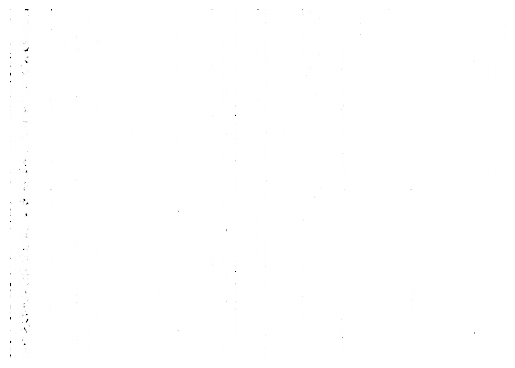

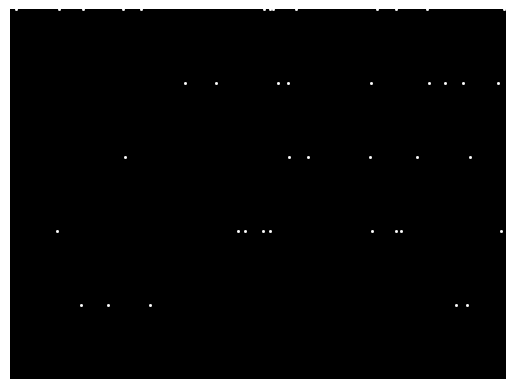

In [9]:
plot_coo_matrix(X, "equal")
plot_coo_matrix(X[:5, :])
print(MASTER_MATRIX[:5, :])

---

Passo 4: Redução de Dimensionalidade

In [10]:
class Node():
	name: str
	parent = None
	children: set

	def __init__(self, name: str):
		self.name = name
		self.children = set()
	
	def __str__(self) -> str:
		return self.name
	
	def get_neighbors(self) -> set:
		return self.children.union({self.parent})
	
	def display(self):
		"""
		Imprime a árvore de forma visual a partir deste nó.
		Este é o método de entrada que o usuário deve chamar.
		"""
		print(str(self))  # Imprime a raiz da sub-árvore
		
		# Ordena os filhos para uma exibição consistente
		children_list = sorted(list(self.children), key=lambda node: node.name)
		
		for i, child in enumerate(children_list):
			is_last = (i == len(children_list) - 1)
			# Inicia a recursão para cada filho do nó atual
			self._display_recursive(child, prefix="", is_last=is_last)

	def _display_recursive(self, node, prefix: str, is_last: bool):
		"""
		Método auxiliar recursivo para imprimir os nós descendentes.
		"""
		# Imprime o nó atual com os conectores da árvore (├── ou └──)
		print(prefix + ("└── " if is_last else "├── ") + str(node))
		
		# Prepara o prefixo para o próximo nível da árvore
		new_prefix = prefix + ("    " if is_last else "│   ")
		
		children_list = sorted(list(node.children), key=lambda n: n.name)
		
		for i, child in enumerate(children_list):
			is_last_child = (i == len(children_list) - 1)
			self._display_recursive(child, new_prefix, is_last_child)

In [11]:
def get_area_values(area: str, RELATEDNESS_FACTOR = 0.5, MAX_DISTANCE = 3, ONLY_SELF: bool = False) -> dict:
	if ONLY_SELF:
		return {area: 1.0}
	
	global areas
	tree = areas
	print(area + "                                                                                               ", end="\r")

	values: dict = {area: 1}
	root = tree["root"]

	# all direct superareas apply fully
	pointer: Node = tree[area]
	while pointer.parent != root:
		values |= {pointer.parent.name: 1}
		pointer = pointer.parent

	#print(values)

	# get relatives
	visited_nodes: set = set()
	parsing: set = {tree[area]}
	for i in range(MAX_DISTANCE):
		neighbors: set = set()
		for node in parsing:
			neighbors.update(node.get_neighbors())
			visited_nodes.add(node)

		parsing.clear()

		for neighbor in neighbors:
			if neighbor == root:
				continue
			
			if neighbor is None:
				continue

			parsing.add(neighbor)
			if neighbor.name not in values:
				values |= {neighbor.name: RELATEDNESS_FACTOR ** i}

		#print(values)

	return values

In [12]:
def plot_coo_matrix_cuda(m, aspect="auto"):
    if not isinstance(m, cupyx.scipy.sparse.coo_matrix):
        m = cupyx.scipy.sparse.coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.get().col, m.get().row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect(aspect)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(m.shape)
    return ax

In [13]:
def plot_coo_matrix_cuda_2(m, aspect="auto", alpha_div=50.0):
	if not isinstance(m, cupyx.scipy.sparse.coo_matrix):
		m = cupyx.scipy.sparse.coo_matrix(m)
	fig = plt.figure()
	ax = fig.add_subplot(111, facecolor='black')
	g = m.get()
	for i in range(m.getnnz()):
		ax.plot(g.col[i], g.row[i], 's', color='white', ms=1, alpha=min(1.0, g.data[i]/alpha_div))
	print(max(m.get().data))
	ax.set_xlim(0, m.shape[1])
	ax.set_ylim(0, m.shape[0])
	ax.set_aspect(aspect)
	for spine in ax.spines.values():
		spine.set_visible(False)
	ax.invert_yaxis()
	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_title(m.shape)
	return ax

In [14]:
def get_sparse(df_training: pd.DataFrame, area_values: dict, areas: dict):
	print(json.dumps(area_values, indent=4))
	indices: dict = {}
	i = 0
	for key in areas:
		indices |= {key: i}
		i += 1

	print(indices)
	row = []
	col = []
	data = []
	extra = 0

	for i in range(len(df_training)):
		values: dict = {}
		for area in df_training["areas"][i]:
			values_based_on_area = area_values[area]

			for area_name in values_based_on_area:
				if area_name in values:
					values[area_name] = max(values[area_name], values_based_on_area[area_name])
				else:
					values |= {area_name: values_based_on_area[area_name]}
			
		for area_name in values:
			row.append(i)
			col.append(indices[area_name])
			data.append(float(values[area_name]))

	row = cupy.array(row)
	col = cupy.array(col)
	data = cupy.array(data)

	print(row.shape)
	print(col.shape)
	print(data.shape)

	for i in range(5):
		print(row[i], col[i], data[i])
	areas_cp = cupyx.scipy.sparse.coo_matrix(
		(data, (row, col)),
		shape=(len(df_training), len(areas))
	)
	print(areas_cp.shape)
	plot_coo_matrix_cuda(areas_cp, "equal")
	return areas_cp

In [15]:
with open("arvore_do_conhecimento.json", "r") as fs:
	arvore_do_conhecimento: dict = json.loads(fs.read())

print(f"{len(arvore_do_conhecimento)} áreas identificadas pelo CNPq e Gemini.")

areas_inputadas: set = set()
for line in data:
	for area in line["areas"]:
		areas_inputadas.add(decode(area))

#print(f"{len(areas_inputadas)} áreas cadastradas no Lattes, das quais {len({area for area in areas_inputadas if area not in arvore_do_conhecimento})} não são canônicas.")
#with open("areas_fantasma.txt", "w") as fs:
#	fs.writelines(list({area + "\n" for area in areas_inputadas if area not in arvore_do_conhecimento}))

3910 áreas identificadas pelo CNPq e Gemini.


In [16]:
#Step 1: build graph
root: Node = Node("root")
areas: dict = {"root": root}

for area_name in arvore_do_conhecimento:
	areas |= {area_name: Node(area_name)}

for area_name in areas:
	if area_name == "root":
		continue
	if arvore_do_conhecimento[area_name]:
		areas[area_name].parent = areas[arvore_do_conhecimento[area_name]]
	else:
		areas[area_name].parent = root

for area_name in areas:
	if area_name == "root":
		continue
	areas[area_name].parent.children.add(areas[area_name])

root.display()

root
├── ciencias agrarias
│   ├── agronomia
│   │   ├── agribusiness
│   │   ├── agricultura familiar
│   │   ├── agrometeorologia
│   │   ├── agronegocio
│   │   ├── ciencia do solo
│   │   │   ├── fertilidade do solo e adubacao
│   │   │   ├── fisica do solo
│   │   │   ├── genese morfologia e classificacao dos solos
│   │   │   ├── genese, morfologia e classificacao dos solos
│   │   │   ├── manejo e conservacao do solo
│   │   │   ├── microbiologia e bioquimica do solo
│   │   │   │   └── microbiologia do solo
│   │   │   ├── quimica do solo
│   │   │   │   └── biochar
│   │   │   └── soil science
│   │   ├── conservacao de etnovariedades cultivares
│   │   ├── entomologia agricola
│   │   │   ├── defesa fitossanitaria
│   │   │   ├── microbiologia agricola
│   │   │   └── parasitologia agricola
│   │   ├── extensao rural
│   │   ├── fitossanidade
│   │   │   └── fitopatologia
│   │   ├── fitotecnia
│   │   │   ├── fisiologia de plantas cultivadas
│   │   │   ├── manejo e tratos c

In [ ]:
MAX_DEPTH: int = 2
tree: dict = {}
weights: dict = {}

for child in root.children:
	tree |= {child.name: (child.parent.name)}
	for grandchild in child.children:
		tree |= {grandchild.name: (grandchild.parent.name)}
		for grandgrandchild in grandchild.children:
			tree |= {grandgrandchild.name: (grandgrandchild.parent.name)}
			for grandgrandgrandchild in grandgrandchild.children:
				tree |= {grandgrandgrandchild.name: (grandgrandgrandchild.parent.name)}

for name in areas:
	node = areas[name]
	w: dict = {}
	while node is not None:
		if node.name in tree:
			w |= {node.name: 1.0}
		node = node.parent
	weights |= {name: w}

print(weights)
with open("area_values.json", "w") as fs:
	fs.write(json.dumps(weights, indent=4))

{'root': {}, 'ciencias agrarias': {'ciencias agrarias': 1.0}, 'ciencias biologicas': {'ciencias biologicas': 1.0}, 'ciencias da saude': {'ciencias da saude': 1.0}, 'ciencias exatas e da terra': {'ciencias exatas e da terra': 1.0}, 'engenharias': {'engenharias': 1.0}, 'ciencias humanas': {'ciencias humanas': 1.0}, 'ciencias sociais aplicadas': {'ciencias sociais aplicadas': 1.0}, 'linguistica; letras e artes': {'linguistica; letras e artes': 1.0}, 'agronomia': {'agronomia': 1.0, 'ciencias agrarias': 1.0}, 'recursos florestais e engenharia florestal': {'recursos florestais e engenharia florestal': 1.0, 'ciencias agrarias': 1.0}, 'engenharia agricola': {'engenharia agricola': 1.0, 'ciencias agrarias': 1.0}, 'zootecnia': {'zootecnia': 1.0, 'ciencias agrarias': 1.0}, 'medicina veterinaria': {'medicina veterinaria': 1.0, 'ciencias agrarias': 1.0}, 'recursos pesqueiros e engenharia de pesca': {'recursos pesqueiros e engenharia de pesca': 1.0, 'ciencias agrarias': 1.0}, 'ciencia e tecnologia d

In [124]:
def build_tree(root) -> dict:
	d = {}
	if root.parent:
		d |= {root.name: root.parent.name}
	for child in root.children:
		d |= build_tree(child)
	return d

In [125]:
tree = build_tree(root)
print(tree)

{'ciencias exatas e da terra': 'root', 'geociencias': 'ciencias exatas e da terra', 'geofisica': 'geociencias', 'aeronomia': 'geofisica', 'sismologia': 'geofisica', 'gravimetria': 'geofisica', 'geomagnetismo': 'geofisica', 'propriedades fisicas das rochas': 'geofisica', 'geofisica aplicada': 'geofisica', 'geofisica nuclear': 'geofisica', 'sensoriamento remoto': 'geofisica', 'remote sensing': 'sensoriamento remoto', 'sensores multiespectrais opticos': 'sensoriamento remoto', 'desenvolvimento de instrumentacao geofisica': 'geofisica', 'geotermia e fluxo termico': 'geofisica', 'geografia fisica': 'geociencias', 'geocartografia': 'geografia fisica', 'hidrogeografia': 'geografia fisica', 'geoecologia': 'geografia fisica', 'geomorfologia fluvial': 'geografia fisica', 'hidrografia': 'geografia fisica', 'geomorfologia': 'geografia fisica', 'biogeografia': 'geografia fisica', 'climatologia geografica': 'geografia fisica', 'pedologia': 'geografia fisica', 'geomorfologia costeira': 'geografia fis

In [119]:
#Step 2: Find all close areas
if "area_values.json" in os.listdir():
	with open("area_values.json", "r") as fs:
		area_values = json.loads(fs.read())
else:
	area_values: dict = {area_name: get_area_values(area_name, MAX_DISTANCE=0, RELATEDNESS_FACTOR=0.0, ONLY_SELF=False) for area_name in areas if area_name != "root"}
	#area_values: list(map(get_area_values, areas.keys()))
	print("done!")
	
	with open("area_values.json", "w") as fs:
		fs.write(json.dumps(area_values, indent=4))

print(json.dumps(area_values, indent=4))


done!s                                                                                                                                                                              
{
    "ciencias agrarias": {
        "ciencias agrarias": 1
    },
    "ciencias biologicas": {
        "ciencias biologicas": 1
    },
    "ciencias da saude": {
        "ciencias da saude": 1
    },
    "ciencias exatas e da terra": {
        "ciencias exatas e da terra": 1
    },
    "engenharias": {
        "engenharias": 1
    },
    "ciencias humanas": {
        "ciencias humanas": 1
    },
    "ciencias sociais aplicadas": {
        "ciencias sociais aplicadas": 1
    },
    "linguistica; letras e artes": {
        "linguistica; letras e artes": 1
    },
    "agronomia": {
        "agronomia": 1,
        "ciencias agrarias": 1
    },
    "recursos florestais e engenharia florestal": {
        "recursos florestais e engenharia florestal": 1,
        "ciencias agrarias": 1
    },
    "engenharia agricol

{
    "ciencias agrarias": {
        "ciencias agrarias": 1
    },
    "ciencias biologicas": {
        "ciencias biologicas": 1
    },
    "ciencias da saude": {
        "ciencias da saude": 1
    },
    "ciencias exatas e da terra": {
        "ciencias exatas e da terra": 1
    },
    "engenharias": {
        "engenharias": 1
    },
    "ciencias humanas": {
        "ciencias humanas": 1
    },
    "ciencias sociais aplicadas": {
        "ciencias sociais aplicadas": 1
    },
    "linguistica; letras e artes": {
        "linguistica; letras e artes": 1
    },
    "agronomia": {
        "agronomia": 1,
        "ciencias agrarias": 1
    },
    "recursos florestais e engenharia florestal": {
        "recursos florestais e engenharia florestal": 1,
        "ciencias agrarias": 1
    },
    "engenharia agricola": {
        "engenharia agricola": 1,
        "ciencias agrarias": 1
    },
    "zootecnia": {
        "zootecnia": 1,
        "ciencias agrarias": 1
    },
    "medicina veterina

<Axes: title={'center': '(50, 3910)'}>

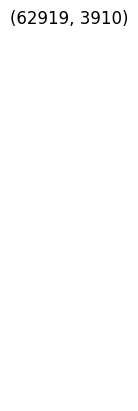

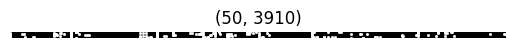

In [126]:
areas_cp = get_sparse(df_training, area_values, tree)
Y = cupyx.scipy.sparse.csr_matrix(areas_cp)
plot_coo_matrix_cuda(Y[:50, :], "equal")

---

# Uma outra ideia...

In [20]:
def axis_norm(M: cupyx.scipy.sparse.csr_matrix, axis: int = 1) -> cupyx.scipy.sparse.csr_matrix:
	#print("\n---")
	try:
		assert type(M) == cupyx.scipy.sparse.csr_matrix, f"Type of M is {type(M)}, should be {cupyx.scipy.sparse.csr_matrix}"
	except AssertionError:
		#print("Attempting to fix the issue...")
		M = cupyx.scipy.sparse.csr_matrix(M)

	# Calculate row sums
	row_sums = M.sum(axis=axis)

	# Convert row_sums to a 1D numpy array for easier manipulation
	row_sums = cupy.asarray(row_sums).flatten()

	# Handle zero row sums to avoid division by zero
	# Replace 0s with 1s for division, rows with original 0 sum will remain 0
	row_sums[row_sums == 0] = 1

	# Create a diagonal matrix with the inverse of row sums
	inv_row_sums = 1.0 / row_sums
	scaling_matrix = cupyx.scipy.sparse.diags(inv_row_sums)

	#print(scaling_matrix.shape)
	#print(M.shape)

	# Perform element-wise multiplication for row-wise normalization
	normalized_matrix = scaling_matrix.dot(M)

	return normalized_matrix

In [127]:
X = cupyx.scipy.sparse.csr_matrix(X)
Y = cupyx.scipy.sparse.csr_matrix(areas_cp)
T = cupyx.scipy.sparse.csr_matrix(T)

print(X.shape) # Essa é a matriz que joga artigos para palavras
print(Y.shape) # Essa é a matriz que joga artigos para áreas
print(T.shape) # Essa é a matriz que tem palavras pra testar

Xn = axis_norm(X).T
Yn = axis_norm(Y.T).T
Tn = axis_norm(T)

#print(Xn.shape) # Essa é a matriz que joga artigos para palavras
#print(Yn.shape) # Essa é a matriz que joga artigos para áreas
#print(Tn.shape) # Essa é a matriz que tem palavras pra testar


(62919, 89504)
(62919, 3910)
(62920, 89504)


In [128]:
M = X.T.dot(Y)
#plot_coo_matrix_cuda(M[:125, :], "equal")
#print(M[:125, :])
#print(X[:125, :])
i = -1
S = X
S = S.power(0)
for k in S.getrow(0).toarray()[0]:
	i += 1
	if k == 0.0:
		continue
	print(k, feature_names[i])


1.0 1st
1.0 aspect
1.0 brazilian
1.0 controversi
1.0 deleg
1.0 jurist
1.0 labor
1.0 law
1.0 meet
1.0 process
1.0 reform
1.0 sidtss
1.0 youth


In [129]:
M = S.T.dot(Y)
print(M.shape)
i = -1
IDX = 0
SEARCH_FOR: str = "algorithm"
for feature in feature_names:
	if feature == SEARCH_FOR:
		break
	IDX += 1
print(IDX, ":", feature_names[IDX])
count = 0


for k in S.T.getrow(IDX).toarray()[0]:
	i += 1
	if k == 0.0:
		continue
	else:
		count += 1
	#print(df_training["title"][i])

print(count)
print("\n")
i = -1
for k in M.getrow(IDX).toarray()[0]:
	i += 1
	if k == 0.0:
		continue
	print("\t", k/count, list(tree.keys())[i])

(89504, 3910)
5532 : algorithm
310


	 0.6451612903225806 ciencias exatas e da terra
	 0.00967741935483871 geociencias
	 0.00967741935483871 geofisica
	 0.00967741935483871 sensoriamento remoto
	 0.012903225806451613 probabilidade e estatistica
	 0.0064516129032258064 estatistica
	 0.0032258064516129032 inferencia nao-parametrica
	 0.0032258064516129032 regressao e correlacao
	 0.0032258064516129032 probabilidade e estatistica aplicadas
	 0.02903225806451613 fisica
	 0.0064516129032258064 areas classicas de fenomenologia e suas aplicacoes
	 0.012903225806451613 fisica geral
	 0.012903225806451613 metrologia; tecnicas gerais de laboratorio; sistema de instrumentacao
	 0.0064516129032258064 metrologia, tecnicas gerais de laboratorio, sistema de instrumentacao
	 0.0064516129032258064 metrologia
	 0.00967741935483871 fisica da materia condensada
	 0.0064516129032258064 superficies e interfaces; peliculas e filamentos
	 0.0032258064516129032 materiais dieletricos e propriedades dieletricas


In [130]:
sums = cupy.asarray(S.sum(axis=0)).flatten()
sums = 1.0 / sums
scaling_matrix = cupyx.scipy.sparse.diags(sums)

print(sums[IDX])
B = scaling_matrix.dot(M)
print(B.getrow(IDX).toarray()[0])

0.0032258064516129032
[0.64516129 0.00967742 0.00967742 ... 0.         0.         0.        ]


In [131]:
print(S.shape)
print(scaling_matrix.shape)

(62919, 89504)
(89504, 89504)


In [138]:
print(T.shape)
print(B.shape)

R = T.dot(B)

def get_correct_areas(areas: list) -> list:
	collected: set = set()

	for area in areas:
		for key in area_values[area]:
			collected.add(key)

	return list(collected)

subareas1 = [name for name in area_values if len(area_values[name]) == 1]
subareas2 = [name for name in area_values if len(area_values[name]) == 2]
subareas = [name for name in area_values if len(area_values[name]) == 2]
subareas3 = [name for name in area_values if len(area_values[name]) == 3]
subareas4 = [name for name in area_values if len(area_values[name]) == 4]

ROW_IDX = 10
pandas_fix = 0
try:
	df_testing[2]
except:
	pandas_fix = len(df_training)


(62920, 89504)
(89504, 3910)


In [ ]:
from difflib import SequenceMatcher

MAX_ROWS = 1000
CORRECT_COUNT = 0.0
CORRECT_COUNT_GRANDE = 0.0
PRINT: bool = False
tree_keys = list(tree.keys())
for ROW_IDX in range(MAX_ROWS):
	correct_areas = get_correct_areas(df_testing["areas"][pandas_fix + ROW_IDX])
	print(f"({ROW_IDX})".ljust(7), df_testing["title"][pandas_fix + ROW_IDX], correct_areas)
	i = -1
	highest = (0.0, "outros")
	highest_grande = (0.0, "outros")
	highest_sub = (0.0, "outros")
	highest_esp = (0.0, "outros")

	for k in R.getrow(ROW_IDX).toarray()[0]:
		i += 1
		if k == 0.0:
			continue
		#print("%6.2f %%  |"%(100*k), list(tree.keys())[i])
		if k > highest[0] and list(tree.keys())[i] in subareas:
			highest = (k, list(tree.keys())[i])
		if k > highest_grande[0] and list(tree.keys())[i] not in subareas:
			highest_grande = (k, list(tree.keys())[i])

	if(PRINT):
		print("   > Predicted area \"%s\" (%.2f %%)"%(highest[1], highest[0]*100.0/len(df_testing["title"][pandas_fix + ROW_IDX].split())))
	for name in correct_areas:
		if SequenceMatcher(None, highest[1], name).ratio() > 0.9:
			CORRECT_COUNT += 1.0
			if(PRINT):
				print("   + CORRECT!", "(%s ≈ %s)"%(highest[1], name) if highest[1] != name else "")
			break
	else:
		if(PRINT):
			print("   - Better luck next time...")
	if(PRINT):
		print("")

	if(PRINT):
		print("   > Predicted grande area \"%s\" (%.2f %%)"%(highest_grande[1], highest_grande[0]*100.0/len(df_testing["title"][pandas_fix + ROW_IDX].split())))
	for name in correct_areas:
		if SequenceMatcher(None, highest_grande[1], name).ratio() > 0.9:
			CORRECT_COUNT_GRANDE += 1.0
			if(PRINT):
				print("   + CORRECT!", "(%s ≈ %s)"%(highest_grande[1], name) if highest_grande[1] != name else "")
			break
	else:
		if(PRINT):
			print("   - Better luck next time...")
	if(PRINT):
		print("")

print("System finished checking %d rows with a success rate of %.2f %% for areas and %.2f %% for great areas."%(MAX_ROWS, CORRECT_COUNT*100.0/MAX_ROWS, CORRECT_COUNT_GRANDE*100.0/MAX_ROWS))

(0)     From the inconvenient truth to sufficient: cosmopolitics of the anthropocene ['ciencias humanas', 'filosofia']
(1)     The Encyclical Letter Evangelium Vitae. Reflecting on the unmatched value of human life ['ciencias humanas', 'teologia moral']
(2)     Documentary series on television: African Pop Travelling-Rasant ['ciencias sociais aplicadas']
(3)     Christian participation in the liturgy from 1 Pedro 2,4-10 ['teologia', 'ciencias humanas', 'teologia pastoral']
(4)     Band Anim'Arte. Visual Identity and Event Set ['comunicacao', 'ciencias sociais aplicadas']
(5)     Expectations of generation Y with leadership. ['administracao', 'ciencias sociais aplicadas']
(6)     The literary genre of symbolic action in the book of the prophet Ezekiel in the light of Eze 4-5: Acts of the Prophet Priest ['teologia', 'ciencias humanas']
(7)     R4 surface silhouette ['ciencias exatas e da terra', 'matematica']
(8)     Interaction in the classroom in Libras and Portuguese with Transdiomati

---

# Agora, a gaussiana!

In [133]:
gauss: dict = {}
i_by_area_name: dict = {list(tree.keys())[i]: i for i in range(len(tree.keys()))}

for i in range(len(df_training)):
	lattes = df_training["lattes"][i]
	year = df_training["year"][i]
	assigned_areas = df_training["areas"][i]

	if lattes not in gauss:
		gauss |= {lattes: {str(year): {"count": 0.0, "areas": cupy.zeros(len(tree.keys()))}}}

	elif str(year) not in gauss[lattes]:
		gauss[lattes] |= {str(year): {"count": 0.0, "areas": cupy.zeros(len(tree.keys()))}}

	gauss[lattes][str(year)]["count"] += 1.0
	for area in get_correct_areas(assigned_areas):
		gauss[lattes][str(year)]["areas"][i_by_area_name[area]] += 1.0

for lattes in gauss:
	for year in gauss[lattes]:
		gauss[lattes][year]["areas"] /= gauss[lattes][year]["count"]


In [134]:
years = list(set(df_labeled["year"]))
years.sort()

gauss_final: dict = {lattes: {year: {"areas": cupy.zeros(len(tree.keys()))} for year in years} for lattes in gauss}
scale = 0.4
exp = 0.5
for lattes in gauss_final:
	for year in gauss_final[lattes]:
		close_years = [str(int(year) + i) for i in range(-3, 4)]
		multipliers = [exp**3, exp**2, exp, 1.0, exp, exp**2, exp**3]

		for i in range(7):
			if close_years[i] not in gauss[lattes]:
				continue
			gauss_final[lattes][year]["areas"] += scale * multipliers[i] * gauss[lattes][close_years[i]]["areas"]

In [137]:
for lattes in gauss_final:
	for year in gauss_final[lattes]:
		print("%s:"%year, sum(gauss_final[lattes][year]["areas"]))
	break

0: 0.0
1964: 0.0
1965: 0.0
1966: 0.0
1967: 0.0
1968: 0.0
1969: 0.0
1970: 0.0
1971: 0.0
1972: 0.0
1973: 0.0
1974: 0.0
1975: 0.0
1976: 0.0
1977: 0.0
1978: 0.0
1979: 0.0
1980: 0.0
1981: 0.0
1982: 0.0
1983: 0.0
1984: 0.0
1985: 0.0
1986: 0.0
1987: 0.0
1988: 0.0
1989: 0.0
1990: 0.0
1991: 0.0
1992: 0.0
1993: 0.0
1994: 0.0
1995: 0.0
1996: 0.0
1997: 0.0
1998: 0.0
1999: 0.0
2000: 0.0
2001: 0.0
2002: 0.0
2003: 0.0
2004: 0.0
2005: 0.0
2006: 0.0
2007: 0.0
2008: 0.0
2009: 0.0
2010: 0.3
2011: 0.8
2012: 1.8250000000000002
2013: 3.900000000000001
2014: 4.425000000000001
2015: 4.844444444444444
2016: 5.130555555555555
2017: 4.973611111111111
2018: 4.922222222222222
2019: 4.961111111111111
2020: 4.680555555555555
2021: 3.727777777777778
2022: 1.7666666666666666
2023: 0.7625
2024: 0.25
2025: 0.0


---

# Ét, voilà?

In [149]:
from difflib import SequenceMatcher

MAX_ROWS = 1000
CORRECT_COUNT_GRANDE = 0
CORRECT_COUNT = 0
CORRECT_COUNT_SUB = 0
CORRECT_COUNT_ESPECIALIDADE = 0
PRINT: bool = False

FROM_TITLE: float = 0.4
FROM_HISTORY: float = 1.0 - FROM_TITLE

tree_keys = list(tree.keys())
CUTOFF = 0

tree_level = [len(area_values[el]) for el in tree_keys]
print(tree_level)

for ROW_IDX in range(MAX_ROWS):
	correct_areas = get_correct_areas(df_testing["areas"][pandas_fix + ROW_IDX])
	i = -1
	highest = (0.0, "outros")
	highest_grande = (0.0, "outros")
	highest_sub = (0.0, "outros")
	highest_esp = (0.0, "outros")

	area_array = R.getrow(ROW_IDX).toarray()[0]

	try:
		g = gauss_final[df_testing["lattes"][pandas_fix + ROW_IDX]][df_testing["year"][pandas_fix + ROW_IDX]]["areas"]
		area_array *= FROM_TITLE / len(df_testing["title"][pandas_fix + ROW_IDX].split())
		area_array += FROM_HISTORY * g
	except:
		pass
	
	for k in area_array:
		i += 1
		if k == 0:
			continue
		#print("%6.2f %%  |"%(100*k), tree_keys[i])

		tki = tree_keys[i]
		match tree_level[i]:
			case 1:
				if k > highest_grande[0]:
					highest_grande = (k, tki)
			case 2:
				if k > highest[0]:
					highest = (k, tki)
			case 3:
				if k > highest_sub[0]:
					highest_sub = (k, tki)
			case 4:
				if k > highest_esp[0]:
					highest_esp = (k, tki)
			case _:
				pass

	observe = "    "

	h1 = highest_grande[1]
	h2 = highest[1]
	h3 = highest_sub[1]
	h4 = highest_esp[1]

	for el in correct_areas:
		match el:
			case h1:
				CORRECT_COUNT_GRANDE += 1
				observe[0] = "O"
			case h2:
				CORRECT_COUNT += 1
				observe[1] = "O"
			case h3:
				CORRECT_COUNT_SUB += 1
				observe[2] = "O"
			case h4:
				CORRECT_COUNT_ESPECIALIDADE += 1
				observe[3] = "O"
			case _:
				continue
				
	
	if highest_grande[1] in correct_areas:
		CORRECT_COUNT_GRANDE += 1
		observe += "O"
	else:
		observe += " "
	if highest[1] in correct_areas:
		CORRECT_COUNT += 1
		observe += "O"
	else:
		observe += " "
	if highest_sub[1] in correct_areas:
		CORRECT_COUNT_SUB += 1
		observe += "O"
	else:
		observe += " "
	if highest_esp[1] in correct_areas:
		CORRECT_COUNT_ESPECIALIDADE += 1
		observe += "O"
	else:
		observe += " "
	print(f"({ROW_IDX})".ljust(7), f"[{observe}]", df_testing["title"][pandas_fix + ROW_IDX], correct_areas)

print("System finished checking %d rows with rates %.2f %% (GA), %.2f %% (A), %.2f %% (SA) and %.2f %% (ESP)."%(MAX_ROWS, CORRECT_COUNT_GRANDE*100.0/MAX_ROWS, CORRECT_COUNT*100.0/MAX_ROWS, CORRECT_COUNT_SUB*100.0/MAX_ROWS, CORRECT_COUNT_ESPECIALIDADE/100.0/MAX_ROWS))

[1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 2, 3, 4, 4, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 2, 2, 3, 4, 5, 4, 4, 5, 5, 4, 4, 5, 5, 5, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 4, 4, 5, 4, 3, 4, 4, 4, 3, 4, 5, 5, 5, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 4, 3, 4, 5, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 5, 6, 3, 4, 5, 4, 4, 5, 4, 4, 4, 4, 5, 5, 4, 4, 5, 5, 4, 4, 4, 4, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 2, 3, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 5, 3, 4, 4, 5, 5, 4, 5, 4, 4, 4, 4, 5, 3, 4, 4, 4, 4, 4, 

In [152]:
print("System finished checking %d rows with rates %.2f %% (GA), %.2f %% (A), %.2f %% (SA) and %.2f %% (ESP)."%(MAX_ROWS, CORRECT_COUNT_GRANDE*100.0/MAX_ROWS, CORRECT_COUNT*100.0/MAX_ROWS, CORRECT_COUNT_SUB*100.0/MAX_ROWS, CORRECT_COUNT_ESPECIALIDADE*100.0/MAX_ROWS))

System finished checking 1000 rows with rates 95.00 % (GA), 71.10 % (A), 56.10 % (SA) and 30.70 % (ESP).


In [34]:
C = MASTER_MATRIX[len(df_labeled):]
C = cupyx.scipy.sparse.csc_matrix(C)

In [35]:
R = C.dot(B)

In [51]:
data_out = {}

with open("data_complete.json", "r") as fs:
	#data_out = {d["tag"]: d for d in json.loads(fs.read())}
	pass

for ROW_IDX in range(len(df_unknown)):
	i = -1
	area_array = FROM_TITLE * R.getrow(ROW_IDX).toarray()[0]
	lattes = df_unknown["lattes"][ROW_IDX]
	highest = (0.0, "outros")
	highest_grande = (0.0, "outros")

	tag = df_unknown["tag"][ROW_IDX]
	if lattes in gauss_final:
		try:
			area_array /= len(df_unknown["title"][ROW_IDX].split())
			area_array += FROM_HISTORY * gauss_final[lattes][int(df_unknown["year"][ROW_IDX])]["areas"]
		except Exception as e:
			print(tag)
			print(e)

	data_out |= {tag: area_array.tolist()}
	print(
	"Processing...   |" +
	"=" * int(100*ROW_IDX/len(df_unknown)) +
	" " * int(100*(len(df_unknown)-ROW_IDX)/len(df_unknown)) +
	"| %5.2f %%"%(100*(ROW_IDX+1)/len(df_unknown)),
	end="\r")
print("All data parsed!")

with open("data_out.json", "w") as fs:
	fs.write(json.dumps(data_out, indent=4))

7840920086364218-e74a1282f37bed5e8285                                                                               |  3.43 %%
1900
6542903895772843-0bd71fe09252901d060c                                                                               | 16.82 %
1900
0424139346325068-c6acca94780a79c43e55                                                                               | 18.05 %
1900
7840920086364218-b5fc72fd3fa8647b9c11                                                                               | 19.53 %
1900
7559560835292228-d5bf15544e7d08d0a360=                                                                              | 21.24 %
1900
7559560835292228-b02caa427ec64d59719a==                                                                             | 22.41 %
1900
5300741216127243-984202388b8fd4a5bed3===                                                                            | 23.60 %
2026
7559560835292228-8244ec7fd9742f888c3f==========                                   

In [77]:
chart_idx = {list(tree.keys())[i]: i for i in range(len(tree.keys()))}
great_area_idx = {key: chart_idx[key] for key in chart_idx if key not in subareas}
sub_area_idx = {key: chart_idx[key] for key in chart_idx if key in subareas}

print(great_area_idx.values())
print(sub_area_idx.values())

chart_matrix = list(data_out.values())
chart_matrix = cupyx.scipy.sparse.csr_matrix(cupy.array(chart_matrix))

print(chart_matrix)


dict_values([0, 10, 27, 40, 57, 65, 81, 98, 114])
dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124])
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11105682 stored elements and shape (152950, 125)>
  Coords	Values
  (0, 0)	0.013689792073806701
  (0, 1)	0.004876935074839958
  (0, 2)	1.4376716263810058e-06
  (0, 3)	0.00030358591514102
  (0, 5)	0.0024480151157165423
  (0, 6)	0.0015068495375465236
  (0, 7)	0.0003292935305014124
  (0, 8)	0.0013361885438537026
  (0, 9)	0.0024187056513777436
  (0, 10)	0.3277184877165221
  (0, 11)	0.000913251413

In [78]:
print(great_area_idx)
print(sub_area_idx)

chart_great_area_matrix = chart_matrix.copy()
for key in sub_area_idx:
	chart_great_area_matrix[:,sub_area_idx[key]] = 0
chart_great_area_matrix.eliminate_zeros()
print(chart_great_area_matrix)

chart_sub_area_matrix = chart_matrix.copy()
for key in great_area_idx:
	chart_sub_area_matrix[:,great_area_idx[key]] = 0
chart_sub_area_matrix.eliminate_zeros()
print(chart_sub_area_matrix)


{'ciencias exatas e da terra': 0, 'engenharias': 10, 'outros': 27, 'ciencias humanas': 40, 'ciencias agrarias': 57, 'ciencias biologicas': 65, 'ciencias sociais aplicadas': 81, 'linguistica; letras e artes': 98, 'ciencias da saude': 114}
{'geociencias': 1, 'astronomia': 2, 'probabilidade e estatistica': 3, 'ciencias exatas': 4, 'fisica': 5, 'quimica': 6, 'oceanografia': 7, 'matematica': 8, 'ciencia da computacao': 9, 'engenharia de materiais e metalurgica': 11, 'engenharia naval e oceanica': 12, 'engenharia medica': 13, 'engenharia': 14, 'engenharia civil': 15, 'engenharia eletrica': 16, 'engenharia sanitaria': 17, 'engenharia de transportes': 18, 'engenharia quimica': 19, 'engenharia biomedica': 20, 'engenharia mecanica': 21, 'engenharia aeroespacial': 22, 'bioengenharia': 23, 'engenharia de minas': 24, 'engenharia nuclear': 25, 'engenharia de producao': 26, 'multidisciplinar': 28, 'tecnologia': 29, 'outra': 30, 'interdisciplinar': 31, 'if sudeste mg': 32, 'tecnologias': 33, 'ciencias

g:\FILES-FOLDER-FULL\Programs\anaconda3\envs\umap\Lib\site-packages\cupyx\scipy\sparse\_compressed.py:548: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive.
  warnings.warn('Changing the sparsity structure of a '


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1347335 stored elements and shape (152950, 125)>
  Coords	Values
  (0, 10)	0.3277184877165221
  (0, 27)	0.00016992815831066467
  (0, 40)	0.01678203115583021
  (0, 57)	0.0001142544437888631
  (0, 65)	0.0022355126319326
  (0, 81)	0.025881346305316074
  (0, 98)	0.002816215340845537
  (0, 114)	0.0011983335486355265
  (1, 0)	0.018800529467243428
  (1, 10)	0.016107555837076102
  (1, 27)	0.0011833834429061767
  (1, 40)	0.08191092181408952
  (1, 57)	6.502858000415011e-05
  (1, 65)	0.006350473060032465
  (1, 81)	0.0283321493755878
  (1, 98)	0.019487171831246614
  (1, 114)	0.003305293690024533
  (2, 0)	0.0056917988765897215
  (2, 10)	0.007161666472719347
  (2, 27)	5.400295933651185e-05
  (2, 40)	0.019481062933839693
  (2, 57)	1.0800591867302373e-05
  (2, 65)	0.0009433333694906991
  (2, 81)	0.4355091479584318
  (2, 98)	0.005694255671094598
  :	:
  (152948, 27)	8.265429053380175e-05
  (152948, 40)	0.23264368851925266
  (152948, 65)	0.00

In [79]:
print(chart_sub_area_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9802281 stored elements and shape (152950, 125)>
  Coords	Values
  (0, 1)	0.004876935074839958
  (0, 2)	1.4376716263810058e-06
  (0, 3)	0.00030358591514102
  (0, 5)	0.0024480151157165423
  (0, 6)	0.0015068495375465236
  (0, 7)	0.0003292935305014124
  (0, 8)	0.0013361885438537026
  (0, 9)	0.0024187056513777436
  (0, 11)	0.0009132514135814959
  (0, 12)	4.354081199619955e-05
  (0, 13)	0.00021132436787307286
  (0, 15)	0.13196474683370849
  (0, 16)	0.0031688514493177044
  (0, 17)	0.18343973530557442
  (0, 18)	0.00020498006120921812
  (0, 19)	0.00017150255831319366
  (0, 20)	2.5812906493280313e-06
  (0, 21)	0.003731175177467218
  (0, 22)	0.0005520122014343072
  (0, 23)	0.00016388457428215532
  (0, 24)	2.5535859537289666e-05
  (0, 25)	0.0004973128209142156
  (0, 26)	0.0018232275516475015
  (0, 31)	1.4376716263810058e-06
  (0, 43)	0.0007217471045107922
  :	:
  (152949, 94)	0.016656434625865676
  (152949, 95)	9.467267546063937e-05
  

In [90]:
area_names = list(tree.keys())

chart_ga = chart_great_area_matrix.argmax(axis=1)
chart_ga = chart_ga[:,0].tolist()
print(chart_ga)

chart_sa = chart_sub_area_matrix.argmax(axis=1)
chart_sa = chart_sa[:,0].tolist()
print(chart_sa)

[10, 40, 81, 0, 0, 81, 98, 81, 81, 81, 0, 0, 40, 81, 98, 81, 98, 40, 81, 10, 40, 0, 81, 0, 40, 40, 10, 81, 10, 98, 40, 81, 10, 81, 0, 81, 81, 40, 40, 98, 10, 40, 10, 81, 40, 81, 81, 10, 40, 81, 81, 40, 40, 0, 40, 81, 81, 81, 40, 81, 10, 81, 40, 98, 10, 40, 40, 10, 10, 81, 40, 81, 81, 81, 40, 40, 81, 65, 81, 81, 81, 98, 40, 40, 10, 81, 98, 40, 40, 40, 81, 0, 10, 40, 10, 10, 81, 40, 0, 98, 0, 10, 40, 81, 81, 40, 40, 40, 81, 40, 40, 0, 81, 81, 40, 98, 40, 40, 98, 0, 10, 40, 40, 0, 81, 81, 10, 40, 81, 81, 40, 40, 81, 0, 40, 40, 81, 81, 98, 40, 40, 40, 81, 81, 10, 40, 10, 81, 98, 81, 81, 40, 0, 10, 81, 40, 10, 0, 10, 40, 40, 81, 81, 40, 81, 0, 40, 40, 81, 57, 0, 40, 40, 81, 10, 81, 0, 81, 98, 40, 81, 0, 81, 40, 40, 40, 40, 81, 40, 40, 81, 40, 0, 40, 81, 40, 40, 40, 10, 40, 81, 40, 40, 40, 81, 0, 0, 40, 81, 40, 40, 40, 98, 81, 81, 10, 81, 81, 10, 81, 81, 10, 81, 10, 10, 10, 81, 40, 98, 0, 81, 81, 81, 40, 81, 10, 98, 81, 81, 0, 81, 40, 81, 81, 81, 10, 81, 40, 0, 0, 0, 98, 40, 81, 81, 10, 81, 

In [93]:
list_ga = [area_names[i] for i in chart_ga]
print(list_ga[:10])

list_sa = [area_names[i] for i in chart_sa]
print(list_sa[:10])

['engenharias', 'ciencias humanas', 'ciencias sociais aplicadas', 'ciencias exatas e da terra', 'ciencias exatas e da terra', 'ciencias sociais aplicadas', 'linguistica; letras e artes', 'ciencias sociais aplicadas', 'ciencias sociais aplicadas', 'ciencias sociais aplicadas']
['engenharia sanitaria', 'educacao', 'direito', 'quimica', 'quimica', 'economia', 'letras', 'direito', 'administracao', 'administracao']


In [116]:
all_areas = []
for el in df_labeled["areas"]:
	s = set()
	for a in el:
		s.update(set(area_values[a].keys()))
	all_areas += list(s)
all_subareas = [el for el in all_areas if el in sub_area_idx]
all_greatareas = [el for el in all_areas if el in great_area_idx]
print(len(all_subareas))
print(len(all_greatareas))

count_base_great = {key: 0 for key in great_area_idx}
count_base_sub = {key: 0 for key in sub_area_idx}
count_new_great = {key: 0 for key in great_area_idx}
count_new_sub = {key: 0 for key in sub_area_idx}

print(set(list_ga))

for el in all_greatareas:
	count_base_great[el] += 1

for el in all_subareas:
	count_base_sub[el] += 1

for el in list_ga:
	try:
		count_new_great[el] += 1
	except KeyError:
		continue

for el in list_sa:
	try:
		count_new_sub[el] += 1
	except KeyError:
		continue
	

129266
141237
{'outros', 'letras', 'musica', 'ciencias sociais aplicadas', 'cinema', 'medicina', 'danca', 'engenharias', 'linguistica; letras e artes', 'ciencias agrarias', 'ciencias da saude', 'ciencias humanas', 'linguistica', 'linguistica letras e artes', 'ciencias exatas e da terra', 'teatro', 'ciencias biologicas'}


In [117]:
for d in [
	count_base_great,
	count_base_sub,
	count_new_great,
	count_new_sub,
]:
	for key in d:
		print(f"{key}\t{d[key]}")
	print("\n\n--\n\n")

ciencias exatas e da terra	16222
engenharias	22015
outros	366
ciencias humanas	42692
ciencias agrarias	178
ciencias biologicas	2247
ciencias sociais aplicadas	40660
linguistica; letras e artes	15622
ciencias da saude	1235


--


geociencias	950
astronomia	21
probabilidade e estatistica	407
ciencias exatas	1
fisica	3467
quimica	2151
oceanografia	208
matematica	1550
ciencia da computacao	7334
engenharia de materiais e metalurgica	4470
engenharia naval e oceanica	18
engenharia medica	234
engenharia	3
engenharia civil	3761
engenharia eletrica	3185
engenharia sanitaria	860
engenharia de transportes	248
engenharia quimica	383
engenharia biomedica	52
engenharia mecanica	5038
engenharia aeroespacial	487
bioengenharia	244
engenharia de minas	99
engenharia nuclear	101
engenharia de producao	2661
multidisciplinar	4
tecnologia	5
outra	1
interdisciplinar	25
if sudeste mg	1
tecnologias	1
ciencias	1
homenagem	1
novas tecnologias	1
interdisciplinariedade	1
applications	1
estudos interdisciplinares	5
c